<a href="https://colab.research.google.com/github/danm00nster/PWML_PROJECT/blob/main/2ML_Daniel_Kwiecinski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Daniel Kwieciński gr II**

Na potrzeby opracowania stworzyłem repozytorium na GIThub w którym zamieszczony jest plik z danymi. W opracowaniu wykorzystuję regresję logistyczną oraz maszynę wektorów nośnych. Do znalezienia najlepszych parametrów zastosowałem GridSearchCV. Wykorzystałem także metodę StandarScaler. Znalazłem również brdzo ciekawy sposób prezentacji wyników jednak nie jestem pewien poprawności jego zastosowania (ostatni wykres).

In [435]:
!git clone https://github.com/danm00nster/PWML_PROJECT

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

fatal: destination path 'PWML_PROJECT' already exists and is not an empty directory.


In [436]:
Cars=pd.read_csv('PWML_PROJECT/car_data.csv')


Przyrzyjmy się jak wyglądają nasze dane

In [437]:
Cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   User ID       1000 non-null   int64  
 1   Gender        1000 non-null   object 
 2   Age           998 non-null    float64
 3   AnnualSalary  997 non-null    float64
 4   Purchased     1000 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 39.2+ KB


Kolumna User ID nie bedzie nam potrzebna. 

In [438]:
Cars=Cars.drop(columns="User ID")
Cars.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,998.0,40.096192,10.712190,18.0,32.0,40.0,48.0,63.0
AnnualSalary,997.0,72676.529589,34442.839132,15000.0,46500.0,72000.0,90000.0,152500.0
Purchased,1000.0,0.402000,0.490547,0.0,0.0,0.0,1.0,1.0


Uzupełnijmy brakujące dane i zróbmy kopię

In [439]:
Cars["Age"]=Cars["Age"].fillna(Cars["Age"].median())
Cars["AnnualSalary"]=Cars["AnnualSalary"].fillna(Cars["AnnualSalary"].median())
Cars_Copy=Cars

Przed dalszą pracą zobaczmy jak przekrojowo wyglądają dane w róznych ujęciach

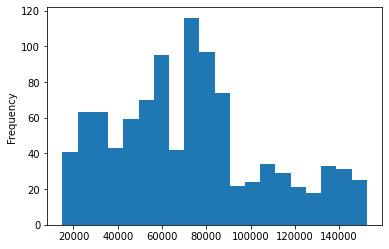

In [440]:
Cars['AnnualSalary'].plot(kind='hist',bins=20)

In [441]:
for columns in ["Age","AnnualSalary","Purchased"]:   
    print(Cars[columns].groupby(Cars['Gender']).mean())

Gender
Female    40.986434
Male      39.146694
Name: Age, dtype: float64
Gender
Female    74676.356589
Male      70540.289256
Name: AnnualSalary, dtype: float64
Gender
Female    0.424419
Male      0.378099
Name: Purchased, dtype: float64


Purchased
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: AnnualSalary, dtype: object

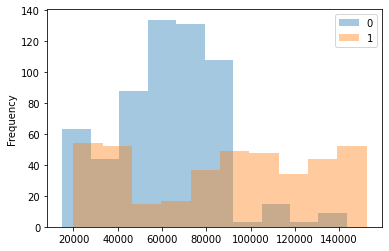

In [442]:
Cars.groupby('Purchased').AnnualSalary.plot(kind='hist',legend=True,alpha=0.4)

In [443]:
print(Cars["Purchased"].groupby(Cars['Gender']).value_counts())

Gender  Purchased
Female  0            297
        1            219
Male    0            301
        1            183
Name: Purchased, dtype: int64


Gender
Female    AxesSubplot(0.125,0.125;0.775x0.755)
Male      AxesSubplot(0.125,0.125;0.775x0.755)
Name: AnnualSalary, dtype: object

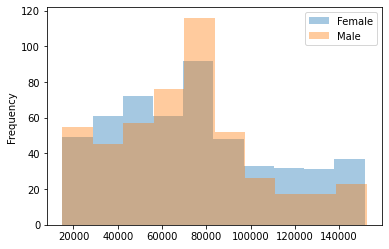

In [444]:

Cars.groupby('Gender').AnnualSalary.plot(kind='hist',legend=True,alpha=0.4)

In [445]:
Cars.head()

,Gender,Age,AnnualSalary,Purchased
0,Male,35.0,20000.0,0
1,Male,40.0,43500.0,0
2,Male,49.0,74000.0,0
3,Male,40.0,107500.0,1
4,Male,25.0,79000.0,0


In [446]:
Cars.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,40.096,10.701463,18.0,32.0,40.0,48.0,63.0
AnnualSalary,1000.0,72674.500,34391.104196,15000.0,46500.0,72000.0,90000.0,152500.0
Purchased,1000.0,0.402,0.490547,0.0,0.0,0.0,1.0,1.0


In [447]:
Cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gender        1000 non-null   object 
 1   Age           1000 non-null   float64
 2   AnnualSalary  1000 non-null   float64
 3   Purchased     1000 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 31.4+ KB


Podzielmy nasze dane na zmienne opisujące (X) i docelowe (y), kolumnę Gender przy okazji zamienimy na dane binarne za pomocą get_dumies

In [448]:
y=Cars.pop("Purchased")



---



In [449]:
Cars=pd.get_dummies(Cars,columns=['Gender'],drop_first=False)
for col in Cars.columns:
    Cars[col] = Cars[col].astype('category')

In [450]:
X=Cars

In [451]:
X.describe().T


,count,unique,top,freq
Age,1000.0,46.0,40.0,48.0
AnnualSalary,1000.0,247.0,81500.0,18.0
Gender_Female,1000.0,2.0,1.0,516.0
Gender_Male,1000.0,2.0,0.0,516.0


In [452]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Age            1000 non-null   category
 1   AnnualSalary   1000 non-null   category
 2   Gender_Female  1000 non-null   category
 3   Gender_Male    1000 non-null   category
dtypes: category(4)
memory usage: 16.7 KB


Utwóżmy zbiory testowe i treningowe z założeniem, że zbóir testowy będzie stanowił 30% całości, ze stałym ziarnem losowania a rozkład kategorii w naszym zbiorze testowym będzie równomierny

In [453]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)
print(y_train.value_counts())
print(y_test.value_counts())

0    419
1    281
Name: Purchased, dtype: int64
0    179
1    121
Name: Purchased, dtype: int64


Utwórzmy model regresji logistycznej i wytrenujmy go na zbiorze treningowym

In [454]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

Na podstawie modelu dokonujemy predykcji i sprawdzamy wyniki

In [455]:
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

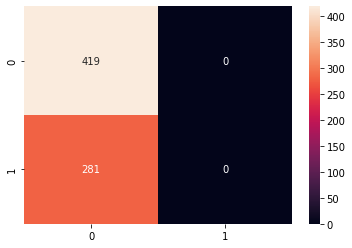

In [456]:
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

In [457]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_train = accuracy_score(y_train, y_pred_train)

precision_train = precision_score(y_train, y_pred_train, average = 'weighted')
recall_train = recall_score(y_train, y_pred_train, average= 'weighted')
f1_train = f1_score(y_train,y_pred_train,average='weighted')

print(f'Accuracy: {np.round(accuracy_train,4)}')
print(f'Precision: {np.round(precision_train,4)}')
print(f'Recall: {np.round(recall_train,4)}')
print(f'F1score: {np.round(f1_train,4)}')

Accuracy: 0.5986
Precision: 0.3583
Recall: 0.5986
F1score: 0.4483


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Regresja Logistyczne nie poradziła sobie zbyt dobrze. Wynik są nieakceptowalne. Spróbujmy ustanadryzować wiek i roczne wynagrodzenie a mastępnie wykonajmy uczenie jeszcze raz na już ustandaryzowanych danych

In [458]:
Cars=Cars_Copy

Standaryzacja wieku i średnich zarobków

---



In [459]:
Cars_val=Cars[['Age','AnnualSalary']]

In [460]:
Cars_gender=pd.get_dummies(Cars[['Gender']])
scaler=StandardScaler()
scaler.fit(Cars_val)
Cars_scaled=scaler.transform(Cars_val)
Cars_scaled=pd.DataFrame(Cars_scaled,index=Cars_val.index,columns=Cars_val.columns)
X=pd.concat([Cars_scaled,Cars_gender], axis=1)


In [461]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            1000 non-null   float64
 1   AnnualSalary   1000 non-null   float64
 2   Gender_Female  1000 non-null   uint8  
 3   Gender_Male    1000 non-null   uint8  
dtypes: float64(2), uint8(2)
memory usage: 17.7 KB


In [462]:
X.describe().T


,count,mean,std,min,25%,50%,75%,max
Age,1000.0,3.304024e-16,1.000500,-2.065798,-0.756911,-0.008975,0.738960,2.141339
AnnualSalary,1000.0,0.000000e+00,1.000500,-1.677857,-0.761464,-0.019622,0.504031,2.322270
Gender_Female,1000.0,5.160000e-01,0.499994,0.000000,0.000000,1.000000,1.000000,1.000000
Gender_Male,1000.0,4.840000e-01,0.499994,0.000000,0.000000,0.000000,1.000000,1.000000


In [463]:
X.head(10)

,Age,AnnualSalary,Gender_Female,Gender_Male
0,-0.476435,-1.532398,0,1
1,-0.008975,-0.848740,0,1
2,0.832452,0.038561,0,1
3,-0.008975,1.013138,0,1
4,-1.411354,0.184020,0,1
5,0.645468,-1.139658,1,0
6,0.551976,1.740434,1,0
7,0.178009,-0.252357,0,1
8,-0.943894,0.344026,1,0
9,0.084517,-0.601459,0,1


Widzimy, że wiek i Srednie zarobki nie mają już wartości w innych skalach. Zobaczmy jak z takimi danymi poradzi sobie regresja logistyczna

In [464]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)
y_train.value_counts()

0    419
1    281
Name: Purchased, dtype: int64

In [465]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [466]:
pred_train = model.predict(X_train)
pred = model.predict(X_test)

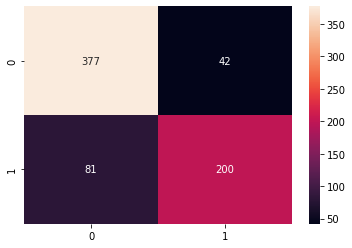

In [467]:
cm_train = confusion_matrix(y_train, pred_train)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

Już na pierwszy rzut oka widać, że wyniki są zdecydowanie lepsze. Sprawdźmy jak wygląda to w szczegółach

In [468]:
accuracy_train = accuracy_score(y_train, pred_train)
precision_train = precision_score(y_train, pred_train, average = 'weighted')
recall_train = recall_score(y_train, pred_train, average= 'weighted')
f1_train = f1_score(y_train,pred_train,average='weighted')

print(f'Accuracy: {np.round(accuracy_train,4)}')
print(f'Precision: {np.round(precision_train,4)}')
print(f'Recall: {np.round(recall_train,4)}')
print(f'F1score: {np.round(f1_train,4)}')

Accuracy: 0.8243
Precision: 0.8245
Recall: 0.8243
F1score: 0.8216


Jak widzimy po standaryzacj wyniki są na przyzwoitym poziomie. Spróbujmy jeszcze je poprawić stosują SVC

In [469]:
svm=SVC(C=0.1,kernel='linear')
svm.fit(X_train,y_train)
pred = svm.predict(X_test)
pred_train = svm.predict(X_train)


In [470]:
accuracy_train = accuracy_score(y_train, pred_train)

precision_train = precision_score(y_train, pred_train, average = 'weighted')
recall_train = recall_score(y_train, pred_train, average= 'weighted')
f1_train = f1_score(y_train,pred_train,average='weighted')

print(f'Accuracy: {accuracy_train}')
print(f'Precision: {np.round(precision_train,4)}')
print(f'Recall: {recall_train}')
print(f'F1score: {np.round(f1_train,4)}')

Accuracy: 0.82
Precision: 0.8229
Recall: 0.82
F1score: 0.8157


Zastosowana metodanie nie zmieniła w sposób znaczący naszych wyników.Zanjadźmy w takim razie najlepsze parametry i najlepsze jądro dla naszej Maszyny Wektorów Nośnych za pomocą GridSearchCV.

In [471]:
from sklearn.model_selection import GridSearchCV
svm = SVC(kernel='rbf')
parameters = {'gamma':[0.001, 0.1, 1],
              'C' : [5, 10, 50],
              'kernel': ['rbf','linear','poly']}
searcher = GridSearchCV(svm, parameters, scoring  = 'f1_macro')
searcher.fit(X_train, y_train)
pred = searcher.predict(X_test)
pred_train = searcher.predict(X_train)
print(f'Accuracy test: {np.round(accuracy_score(y_test, pred),4)}')
print(f'Accuracy train {np.round(accuracy_score(y_train, pred_train),4)}')
print("Best CV params", searcher.best_params_)

Accuracy test: 0.9233
Accuracy train 0.9143
Best CV params {'C': 5, 'gamma': 1, 'kernel': 'rbf'}


In [472]:
svm=SVC(C=10,kernel='rbf',gamma=1)
svm.fit(X_train,y_train)
pred = svm.predict(X_test)
pred_train = svm.predict(X_train)

In [473]:
accuracy_train = accuracy_score(y_train, pred_train)

precision_train = precision_score(y_train, pred_train, average = 'weighted')
recall_train = recall_score(y_train, pred_train, average= 'weighted')
f1_train = f1_score(y_train,pred_train,average='weighted')

print(f'Accuracy: {np.round(accuracy_train,4)}')
print(f'Precision: {np.round(precision_train,4)}')
print(f'Recall: {np.round(recall_train,4)}')
print(f'F1score: {np.round(f1_train,4)}')

Accuracy: 0.9171
Precision: 0.9191
Recall: 0.9171
F1score: 0.9175


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


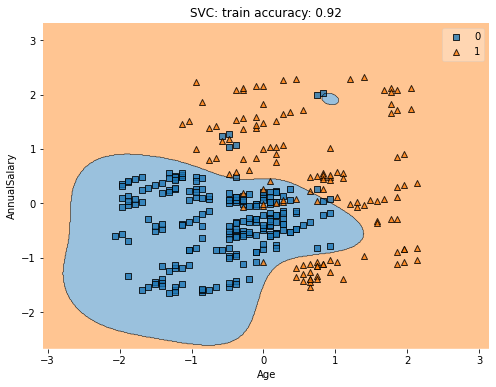

In [474]:
from mlxtend.plotting import plot_decision_regions
plt.figure(figsize=(8, 6))
plot_decision_regions(X_train.to_numpy(), y_train.to_numpy(), svm,
                      filler_feature_values={2: 0, 3: 1},
                      filler_feature_ranges={2: 1, 3: 1},)
plt.xlabel(X_train.columns[0])
plt.ylabel(X_train.columns[1])
plt.title(f'SVC: train accuracy: {svm.score(X_train, y_train):.2f}')
plt.show()

Wynik jest już bardzo dobry. Można jeszcze próbować go poprawić zwiękaszjąc zakres przeszukiwanych parametrów C czy gamma lub stosując inne jądra ale jest raczej mało prawdopodobne aby uzyskać znacząco lepszy efekt.

Dziękuję za uwagę,
Daniel Kwieciński